In [200]:
!pip install yfinance
!pip install newsapi-python
!pip install pmdarima
!pip install visualize

  Created wheel for visualize: filename=visualize-0.5.1-py3-none-any.whl size=11467 sha256=2435ee1c8e3781900783f3114cfdbff550aa628004b0cc9e4ff8690354aed746
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\9d\06\26\944128c987db913298520c2b476bb652faf6a5d00accb3f59c
Successfully built visualize


In [64]:
!pip install pmdarima --user

  Using cached pmdarima-1.8.4-cp38-cp38-win_amd64.whl (600 kB)


Package                            Version
---------------------------------- -------------------
-tatsmodels                        0.12.0
absl-py                            0.15.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.10.0
anaconda-project                   0.8.3
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.4.2
astropy                            4.0.2
astunparse                         1.6.3
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.4
Babel                              2.8.1
backcall                           0.2.0
backports.functools-lru-cache      1.6.1
backports.shutil-get-terminal-size 1.0.0
backports.tempfile                 1.0
backports.weakref                  1.

In [267]:
import yfinance as yf
from statsmodels.tsa.arima_model import ARIMA
from newsapi import NewsApiClient
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
import math
from sklearn.metrics import mean_squared_error

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [328]:
def plot_basic(stocks, title='Close Price', y_label='Price USD', x_label='Trading Days'):
    fig, ax = plt.subplots()
    ax.plot(stocks['Close'], '#0A7388')
    ax.set_title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()
    
    

def plot_prediction(actual, prediction, title='Yahoo Finance vs Prediction', y_label='Price USD', x_label='Trading Days'):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    # Plot actual and predicted close values

    plt.plot(actual, '#00FF00', label='Adjusted Close')
    plt.plot(prediction, '#0000FF', label='Predicted Close')

    # Set title
    ax.set_title(title)
    ax.legend(loc='upper left')

    plt.show()


In [213]:

#### GET STOCK DATA using TICKER YAHOO FINANCE API ####
def get_data_stock(stock_ticker,start_dt,end_dt):

    #define the ticker symbol
    tickerSymbol = stock_ticker

    #get data on this ticker
    tickerData = yf.Ticker(tickerSymbol)

    #get the historical prices for this ticker
    tickerDf = tickerData.history(period='1d', start=start_dt, end=end_dt)

    #see your data
    tickerDf['Item'] = np.arange(len(tickerDf))
    return tickerDf[['Item','Open', 'Close', 'Volume']]


In [193]:
##### Function to normalize the data features ####
def get_normalised_data(data):
    # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler()
    numerical = ['Open', 'Close', 'Volume']
    data[numerical] = scaler.fit_transform(data[numerical])
    return data
`


In [268]:
def get_rmse(actual,predicted):
    return math.sqrt(mean_squared_error(actual,predicted))

In [221]:
def scale_range(x, input_range, target_range):
    """
    Rescale a numpy array from input to target range
    :param x: data to scale
    :param input_range: optional input range for data: default 0.0:1.0
    :param target_range: optional target range for data: default 0.0:1.0
    :return: rescaled array, incoming range [min,max]
    """

    range = [np.amin(x), np.amax(x)]
    x_std = (x - input_range[0]) / (1.0*(input_range[1] - input_range[0]))
    x_scaled = x_std * (1.0*(target_range[1] - target_range[0])) + target_range[0]
    return x_scaled, range

In [329]:

def train_test_split_linear_regression(stocks):
    """
        Split the data set into training and testing feature for Linear Regression Model
        :param stocks: whole data set containing ['Open','Close','Volume'] features
        :return: X_train : training sets of feature
        :return: X_test : test sets of feature
        :return: y_train: training sets of label
        :return: y_test: test sets of label
        :return: label_range: scaled range of label used in predicting price,
    """
    # Create numpy arrays for features and targets
    feature = []
    label = []

    # Convert dataframe columns to numpy arrays for scikit learn
    for index, row in stocks.iterrows():
        # print([np.array(row['Item'])])
        feature.append([(row['Item'])])
        label.append([(row['Close'])])
    #print(feature)
    #print(label)

    # Regularize the feature and target arrays and store min/max of input data for rescaling later
    feature_bounds = [min(feature), max(feature)]
    feature_bounds = [feature_bounds[0][0], feature_bounds[1][0]]
    label_bounds = [min(label), max(label)]
    label_bounds = [label_bounds[0][0], label_bounds[1][0]]

    feature_scaled, feature_range = scale_range(np.array(feature), input_range=feature_bounds, target_range=[-1.0, 1.0])
    label_scaled, label_range = scale_range(np.array(label), input_range=label_bounds, target_range=[-1.0, 1.0])

    # Define Test/Train Split 80/20
    split = .20
    split = int(math.floor(len(stocks['Item']) * split))
    ##print(split)
    # Set up training and test sets
    X_train = feature_scaled[:-split]
    X_test = feature_scaled[-split:]

    y_train = label_scaled[:-split]
    y_test = label_scaled[-split:]

    return X_train, X_test, y_train, y_test, label_range
    
    

In [326]:
def train_test_split_lstm(stocks,history=60):
    close_price=stocks.filter(['Close']).values
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(close_price)
    train_len = math.ceil(0.8*len(close_price))
    train_data = scaled_data[0:train_len,:]
    test_data = scaled_data[train_len:,:]
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    #### Prepare data for sequential Model Train ####
    for i in range(history,len(train_data)):
        x_train.append(train_data[i-history:i,0])
        y_train.append(train_data[i,0])
        
    #### Prepare data for sequential Model Test ####
    for i in range(history,len(test_data)):
        x_test.append(test_data[i-history:i,0])
        y_test.append(test_data[i,0])
    
    ### convert to numpy array ###
    x_train,y_train = np.array(x_train),np.array(y_train)
    x_test,y_test = np.array(x_test),np.array(y_test)
    
    ### RESHAPE AS expected by LSTM Model (rows,columns,features)
    x_train = np.reshape(x_train,(len(x_train),history,1))
    x_test = np.reshape(x_test,(len(x_test),history,1))
    return x_train,y_train,x_test,y_test,scaler
    
    
def build_lstm_model(x_train,y_train):
    model = Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(LSTM(50,return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(x_train,y_train,batch_size=1,epochs=1)
    return model
    
x_train,y_train,x_test,y_test,scaler = train_test_split_lstm(df_stock,15)
lstm_model = build_lstm_model(x_train,y_train)




741/741 [==============================] - 26s 23ms/step - loss: 0.0012


5.938722215803122


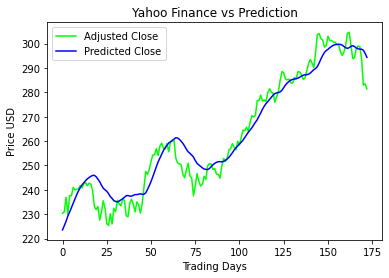

In [327]:
predictions = lstm_model.predict(x_test)
#print(predictions.shape)
#print(y_test.shape)
predictions = scaler.inverse_transform(predictions)
##print(y_test)
actuals = scaler.inverse_transform(np.reshape(y_test,(y_test.shape[0],1)))
print(get_rmse(np.array(actuals),np.array(predictions)))
plot_prediction(actuals,predictions)


In [312]:
x_test

array([], shape=(0, 60, 1), dtype=float64)

In [ ]:
def

In [261]:
def Linear_RegressionModel(X,y):
    linear_mod = linear_model.LinearRegression()
    X = np.reshape(X, (X.shape[0], 1))
    y = np.reshape(y, (y.shape[0], 1))
    linear_mod.fit(X, y)  # fitting the data points in the model
    return linear_mod

def Linear_model_predict(model, x, label_range):
    x = np.reshape(x, (x.shape[0], 1))
    #print(x)
    predicted_price = model.predict(x)
    #print(predicted_price)
    predictions_rescaled, re_range = scale_range(predicted_price, input_range=[-1.0, 1.0], target_range=label_range)
    #print(predictions_rescaled)
    return predicted_price.flatten()


In [4]:
#### GET NEWS from NEWS API #####
### API KEY : 0b2277b448e44ddbbdb1e4b45dcb8f64 ###

def get_news(stock_ticker):
    api = NewsApiClient(api_key='0b2277b448e44ddbbdb1e4b45dcb8f64')
    j = api.get_everything(q=stock_ticker)
    return j

def get_news_content(stock_ticker):
    news = get_news(stock_ticker)
    for i in news['articles']:
        print(i['title'])



In [189]:
get_news_content('MSFT')

Microsoft's (MSFT) Q1 Earnings & Revenues Surpass Estimates
Microsoft's (MSFT) Q1 Earnings & Revenues Surpass Estimates
5 Blue-Chip Stock to Buy as Dow Crosses a Fresh Milestone
4 Stocks to Watch in a Booming Videogame Industry
Top Research Reports for Microsoft, Berkshire Hathaway & Oracle
A Deep Dive into the Microsoft (MSFT) and Alphabet (GOOGL) Earnings Charts
Are Stocks in a Bubble?
Big Tech, Tesla & An ETF to Invest in Disruption
VOTE: ESG Activism in an ETF
Zacks Market Edge Highlights: Microsoft, Cisco, QUALCOMM, NVIDIA and Tesla
Why giant companies are splitting into pieces
Bull of the Day: Salesforce (CRM)
S&P and Dow Step Back From Record Highs
Should Vanguard S&P 500 ETF (VOO) Be on Your Investing Radar?
Should WisdomTree U.S. Total Dividend ETF (DTD) Be on Your Investing Radar?
Should Vanguard LargeCap ETF (VV) Be on Your Investing Radar?
Should Invesco QQQ (QQQ) Be on Your Investing Radar?
Is John Hancock Multifactor Large Cap ETF (JHML) a Strong ETF Right Now?
Should iSh

In [325]:
df_stock = get_data_stock('MSFT','2018-01-01','2021-10-01')

In [112]:
df_results = pd.DataFrame(columns = ['Actual','Forecast'])
df_results

,Actual,Forecast


In [191]:
### SARIMA MODEL GENERATION ###
def sarima_model(df_train,df_test,p=1,d=1,q=1):
    # Fit auto_arima function
    '''stepwise_fit = auto_arima(df_train['Close'] start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise

  
    # To print the summary
    stepwise_fit.summary()
    '''
    model = SARIMAX(df_train['Close'],order = (0, 1, 1),seasonal_order =(2, 1, 1, 30))
    sarima_model = model.fit()
    #print(result.summary())
    start = len(df_train)
    end = len(df_train) + len(df_test) - 1
    df_results = pd.DataFrame()
    indexes = df_test.index
    print(indexes)
    predictions = sarima_model.predict(start, end)
    df_results['Date'] = indexes
    df_results['Forecast'] = pd.DataFrame(predictions).reset_index().loc[:,'predicted_mean']
    df_results['Actual']=df_test.reset_index().loc[:,'Close']
    df_results.set_index('Date',inplace=True)
    ##print(len(df_results),len(indexes))
    ##print(df_results)
    df_results.plot(y=["Actual", "Forecast"], kind="line")
    #predictions.plot(legend = True)
    #df_test['Close'].plot(legend = True)
       

In [81]:
predictions

NameError: name 'predictions' is not defined

In [187]:
def train_test_split(df,start,end):
    train_set = df_stock.loc['2018-01-01': '2021-01-01']
    train_set
    test_set = df_stock.loc['2021-01-02':]
    test_set
    print(test_set)

                   Open         High          Low        Close   Volume  \
Date                                                                      
2021-01-04  3270.000000  3272.000000  3144.020020  3186.629883  4411400   
2021-01-05  3166.010010  3223.379883  3165.060059  3218.510010  2655500   
2021-01-06  3146.479980  3197.510010  3131.159912  3138.379883  4394800   
2021-01-07  3157.000000  3208.540039  3155.000000  3162.159912  3514500   
2021-01-08  3180.000000  3190.639893  3142.199951  3182.699951  3537700   
...                 ...          ...          ...          ...      ...   
2021-09-24  3402.010010  3429.260010  3393.399902  3425.520020  2116200   
2021-09-27  3371.500000  3415.570068  3339.610107  3405.800049  3634500   
2021-09-28  3357.709961  3369.189941  3290.100098  3315.959961  4430800   
2021-09-29  3322.110107  3351.300049  3297.870117  3301.120117  2562300   
2021-09-30  3316.000000  3327.850098  3273.989990  3285.040039  2842400   

            Dividends  S

DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2021-09-17', '2021-09-20', '2021-09-21', '2021-09-22',
               '2021-09-23', '2021-09-24', '2021-09-27', '2021-09-28',
               '2021-09-29', '2021-09-30'],
              dtype='datetime64[ns]', name='Date', length=188, freq=None)


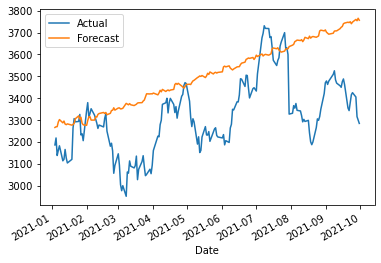

In [188]:

#### CALL SARIMA MODEL ####
sarima_model(train_set,test_set)

In [194]:
###### LSTM Modelling #########

def lstm_model(df_train,df_test):
    ef build_basic_model(input_dim, output_dim, return_sequences):
    """
    Builds a basic lstm model 
    :param input_dim: input dimension of the model
    :param output_dim: output dimension of the model
    :param return_sequences: return sequence of the model
    :return: a basic lstm model with 3 layers.
    """
    model = Sequential()
    model.add(LSTM(
        input_shape=(None, input_dim),
        units=output_dim,
        return_sequences=return_sequences))

    model.add(LSTM(
        100,
        return_sequences=False))

    model.add(Dense(
        units=1))
    model.add(Activation('linear'))

    return model

SyntaxError: unexpected EOF while parsing (<ipython-input-194-c321557c910b>, line 4)

0.6655238088807889


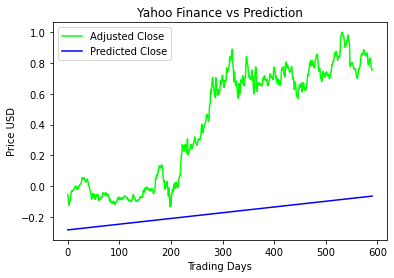

In [269]:
####### START HERE ##################################



### SET THE VARIABLES TO extract Data #####
stock_ticker = 'AMZN'
start_dt = '2010-01-01'
end_dt = '2021-10-01'



### GET TICKER DATA ###
df_stock = get_data_stock(stock_ticker,start_dt,end_dt);
#print(df_stock)




### PLOT STOCK data ###
#plot_basic(df_stock)





### NORMALIZE DATA for STOCK ###




### GENERATE A BASIC LINEAR REGRESSION MODEL ###

x_train,x_test,y_train,y_test,yrange = train_test_split_linear_regression(df_stock)
#print("x_train", x_train)
#print("y_train", y_train)
#print("x_test", x_test)
#print("y_test", y_test)

lm_model = Linear_RegressionModel(x_train,y_train);
predictions = Linear_model_predict(lm_model,x_test,yrange)

### PLOT BASIC LINEAR REGRESSION MODEL RESULTS ###
plot_prediction(y_test,predictions)
print(get_rmse(y_test,predictions))


### GENERATE SARIMAX FORECASTING MODEL ###



#### PLOT SARIMAX RESULTS ####



### GENERATE LSTM MODEL ###




### PLOT LSTM RESULTS ###













